In [1]:
import hyrax
from pathlib import Path
import re
import toml
import matplotlib.pyplot as plt
import numpy as np

from hyrax.data_sets.inference_dataset import InferenceDataSet
import pandas as pd
import glob
import logging

In [2]:
def extract_exp_from_run(target_run_number):
    import os
    all_umap_list = sorted(glob.glob("results/*umap*"))
    
    for um in all_umap_list:
        if os.path.exists(f"{um}/original_dataset_config.toml"):
            run_number = toml.load(f"{um}/original_dataset_config.toml")["train"]["run_name"]

            # print(run_number, um)
            if int(run_number.split("_")[1][-2:]) == target_run_number:
                print(run_number, um)

def extract_infer_from_run(target_run_number):
    import os
    all_umap_list = sorted(glob.glob("results/*infer*"))
    
    for um in all_umap_list:
        if os.path.exists(f"{um}/original_dataset_config.toml"):
            run_number = toml.load(f"{um}/original_dataset_config.toml")["train"]["run_name"]

            print(run_number, um)
            # if int(run_number.split("_")[1][-2:]) == target_run_number:
            #     print(run_number, um)

In [3]:
extract_exp_from_run(6)

run02_06 results/20250730-083241-umap-dqoc
run03_06 results/20250802-045700-umap-LlF6
run_06_01 results/20250821-024312-umap-z-jP
run_06_03 results/20250821-075011-umap-Luyk
run_06_04 results/20250821-083306-umap-esGx
run_06_02 results/20250821-091632-umap-mg2o
run_06_05 results/20250824-085526-umap-c5uW
run_06_06 results/20250824-093955-umap-Mcmr
run_06_07 results/20250825-090306-umap-crRW
run_06_08 results/20250825-090459-umap-pmMz
run_06_09 results/20250825-090650-umap-BDSR
run_06_10 results/20250825-090839-umap-Zqyk
run_06_11 results/20250825-091021-umap-kafo
run_06_12 results/20250825-091208-umap-0mpz
run_06_13 results/20250826-081411-umap-2pe5
run_06_14 results/20250826-081723-umap-3zMm
run_06_15 results/20250826-082037-umap-hpjo
run_06_16 results/20250826-082334-umap-rv2e
run_06_17 results/20250826-082632-umap-_PUY
run_06_18 results/20250826-082933-umap-WrRp
run_06_09 results/20250930-223644-umap-QF34
run_06_13 results/20250930-230206-umap-NDN4
run_06_13 results/20251001-132727-

In [93]:
def plot_umap_overlay(ax, config=None, key=None, threshold=0.3, database=None, input_dir=None, title=None, alpha=0.6, s=1, color=None,
                       color_column=None, vmin=None, vmax=None, log_colorbar=False, print_rubin_ids=False, overriding_indices=None):
    
    from hyrax.data_sets.inference_dataset import InferenceDataSet
    from matplotlib.colors import LogNorm, Normalize
    import copy
      
    # Load UMAP results
    umap_results = plot_one_umap(input_dir)
    
    # Extract 2D coordinates
    points = np.array([point.numpy() for point in umap_results])
    x, y = points[:, 0], points[:, 1]

    # Copy to plot the entire thing
    all_x, all_y = copy.deepcopy(x), copy.deepcopy(y)
    
    # Extract Rubin ID information
    rubin_ids = np.array([idx[0] for idx in umap_results.batch_index], dtype=np.int64)
    database_filtered = database[(database["rubin_object_id"].isin(rubin_ids)) & (database[key] >= threshold)]

    
    if overriding_indices is not None:
        print("Using overriding indices...")
        filtered_idx = np.array([idx for idx, _ in enumerate(rubin_ids) if str(_) in overriding_indices])
    else:
        filtered_idx = np.array([idx for idx, _ in enumerate(rubin_ids) if _ in database_filtered["rubin_object_id"].to_list()])

    if print_rubin_ids:
        print(filtered_idx)
        print(rubin_ids[filtered_idx])

    # Filter x and y
    x = x[filtered_idx]
    y = y[filtered_idx]

    # # Handle color specification
    # color_values = 1.
    colorbar_label = None

    if overriding_indices is not None:
        color_values = database[(database["rubin_object_id"].isin(overriding_indices))][key]
        print(color_values)
    else: 
        color_values = database_filtered[key]
        
    cmap = "viridis"

    # Regular scatter plot
    if color_values is not None:
        # Determine normalization
        if log_colorbar:
            # Ensure positive values for log scaling
            if np.any(color_values <= 0):
                min_positive = np.min(color_values[color_values > 0]) if np.any(color_values > 0) else 1e-10
                color_values = np.maximum(color_values, min_positive)
                print(f"Warning: Non-positive values found, clamped to {min_positive} for log scaling")

            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = Normalize(vmin=vmin, vmax=vmax)
        
        _ = ax.scatter(all_x, all_y, alpha=alpha, s=s)
        if overriding_indices is not None:
            scatter = ax.scatter(x, y, alpha=1.0, s=20, norm=norm, marker="x")
        else:
            scatter = ax.scatter(x, y, alpha=1.0, s=20, c=color_values, cmap=cmap, norm=norm, marker="x")
        cbar = plt.colorbar(scatter, ax=ax, label=colorbar_label)
    else:
        scatter = ax.scatter(all_x, all_y, alpha=alpha, s=s)
        
    # Styling
    if title is not None:
        ax.set_title(title)
    
    return ax

def plot_one_umap(umap_name):
    """Manually plot one umap"""
    umap_dir = f"results/{umap_name}/"

    original_config_filepath = glob.glob(f"{umap_dir}/origin*")

    logging.disable(logging.CRITICAL)
    umap_results = InferenceDataSet(original_config_filepath, results_dir=umap_dir, verb="umap")
    logging.disable(logging.NOTSET)

    return umap_results

In [51]:
euclid_path = "/astro/store/epyc2/data/aritrag/comcam_dp1/external_catalogs/xmatched_cats/rubin_euclid_spatial.parquet"
euclid = pd.read_parquet(euclid_path)

euclid_vissyn = pd.read_parquet("/astro/store/epyc2/data/aritrag/comcam_dp1/external_catalogs/xmatched_cats/rubin_euclid_vissyn.parquet")

In [52]:
exp_df = pd.read_csv("exp_list_run_06.csv")

exp_df

,exp_name,umap_filename
0,run_06_07,20250825-090306-umap-crRW
1,run_06_08,20250825-090459-umap-pmMz
2,run_06_09,20250825-090650-umap-BDSR
3,run_06_10,20250825-090839-umap-Zqyk
4,run_06_11,20250825-091021-umap-kafo
5,run_06_12,20250825-091208-umap-0mpz
6,run_06_13,20250826-081411-umap-2pe5
7,run_06_14,20250826-081723-umap-3zMm
8,run_06_15,20250826-082037-umap-hpjo
9,run_06_16,20250826-082334-umap-rv2e


Text(0.5, 0.98, 'run_06_13')

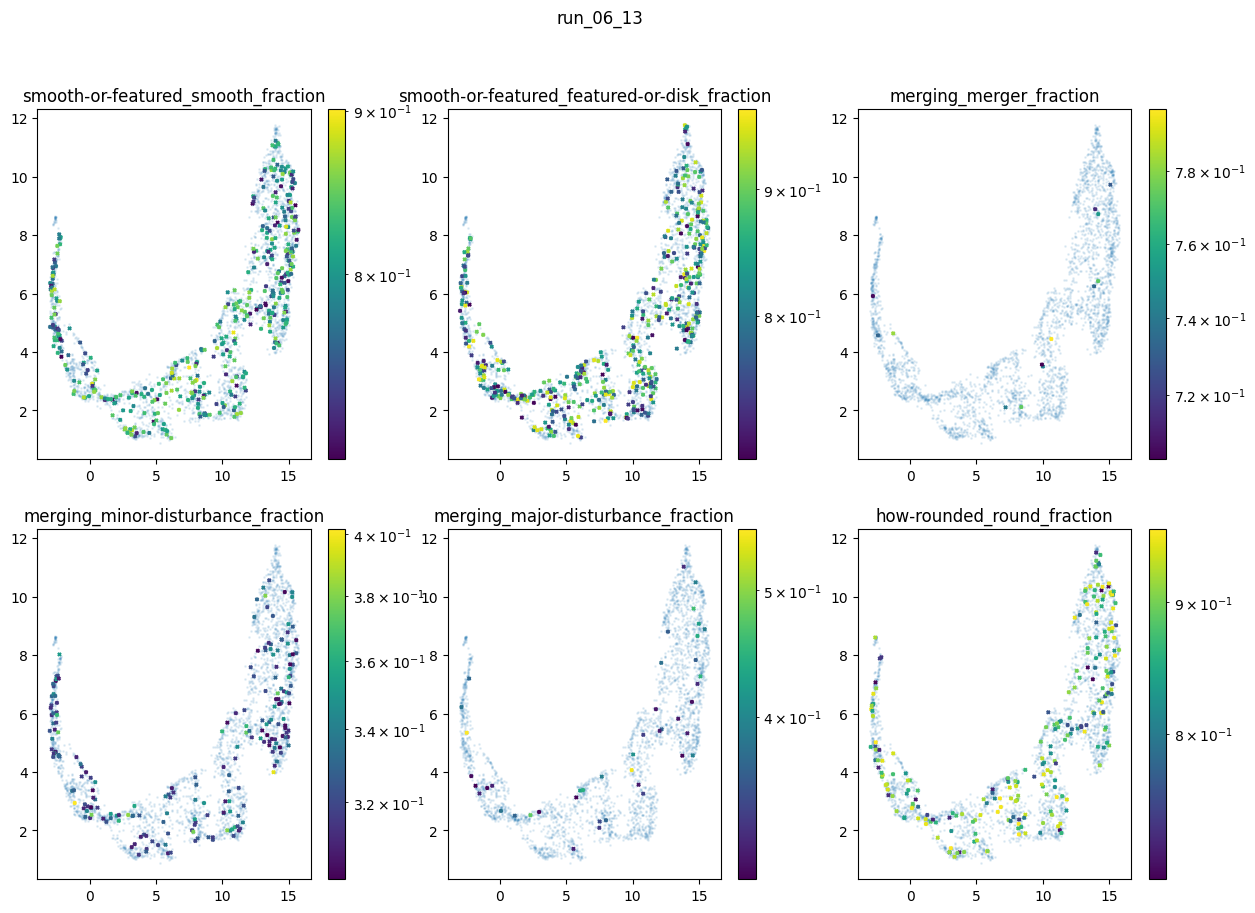

In [11]:
# Feature plots of run_06_14

# Features of interest
interested_cols = [
    "smooth-or-featured_smooth_fraction",
    "smooth-or-featured_featured-or-disk_fraction",
    "merging_merger_fraction",
    "merging_minor-disturbance_fraction",
    "merging_major-disturbance_fraction",
    "how-rounded_round_fraction",
    # "how-rounded_cigar-shaped_fraction",
    # "bar_strong_fraction",
    # "disk-edge-on_yes_fraction",
]

expnum = 6

fig, axes = plt.subplots(2, 3, figsize=(15,10))

thres_arr = [0.7, 0.7, 0.7, 0.3, 0.3, 0.7]


for i, ax in enumerate(axes.flatten()):
    plot_umap_overlay(ax, config=None, key=interested_cols[i], threshold=thres_arr[i],
                      database=euclid_vissyn, input_dir=exp_df.loc[expnum, "umap_filename"], alpha=0.1, s=1,
                     log_colorbar=True, title=interested_cols[i])

fig.suptitle(exp_df.loc[expnum, "exp_name"])

In [ ]:
# Feature plots of all runs with `merger`

# Features of interest
# interested_cols = [
#     "smooth-or-featured_smooth_fraction",
#     "smooth-or-featured_featured-or-disk_fraction",
#     "merging_merger_fraction",
#     "merging_minor-disturbance_fraction",
#     "merging_major-disturbance_fraction",
#     "how-rounded_round_fraction",
#     # "how-rounded_cigar-shaped_fraction",
#     # "bar_strong_fraction",
#     # "disk-edge-on_yes_fraction",
# ]

expnum = 6


# thres_arr = [0.7, 0.7, 0.7, 0.3, 0.3, 0.7]

fig, axes = plt.subplots(6, 2, figsize=(10,30))

for i, ax in enumerate(axes.flatten()):
    plot_umap_overlay(ax, config=None, key="merging_merger_fraction", threshold=0.75,
                      database=euclid_vissyn, input_dir=exp_df.loc[i, "umap_filename"], alpha=0.01, s=1,
                     log_colorbar=True, title=exp_df.loc[i, "exp_name"])

Using overriding indices...
[ 1486  1488  1501  1544  1564  1875  2554  2596  2761  3386  3507  3613
  3614  4633  6488  6583  6926  8687  8936 11292 13948 15140 15394 15577
 15627]
[609781589622146743 609781589622146757 609781589622146910
 609781589622148410 609781589622149000 609782276816907704
 609788117972428945 609788117972430024 609788186691908062
 609788667728239378 609788736447723861 609788736447726513
 609788736447726514 609789354923011356 611254179289118356
 611254179289120892 611254248008602801 611254591605987716
 611254866483883349 611255278800751261 611255965995515915
 611256515751330523 611256584470800559 611256584470805623
 611256584470806644]
Series([], Name: total_mergers_fraction, dtype: float32)


/tmp/ipykernel_111014/3977599171.py:65: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  scatter = ax.scatter(x, y, alpha=1.0, s=20, norm=norm, marker="x")


<Axes: title={'center': 'mergers'}>

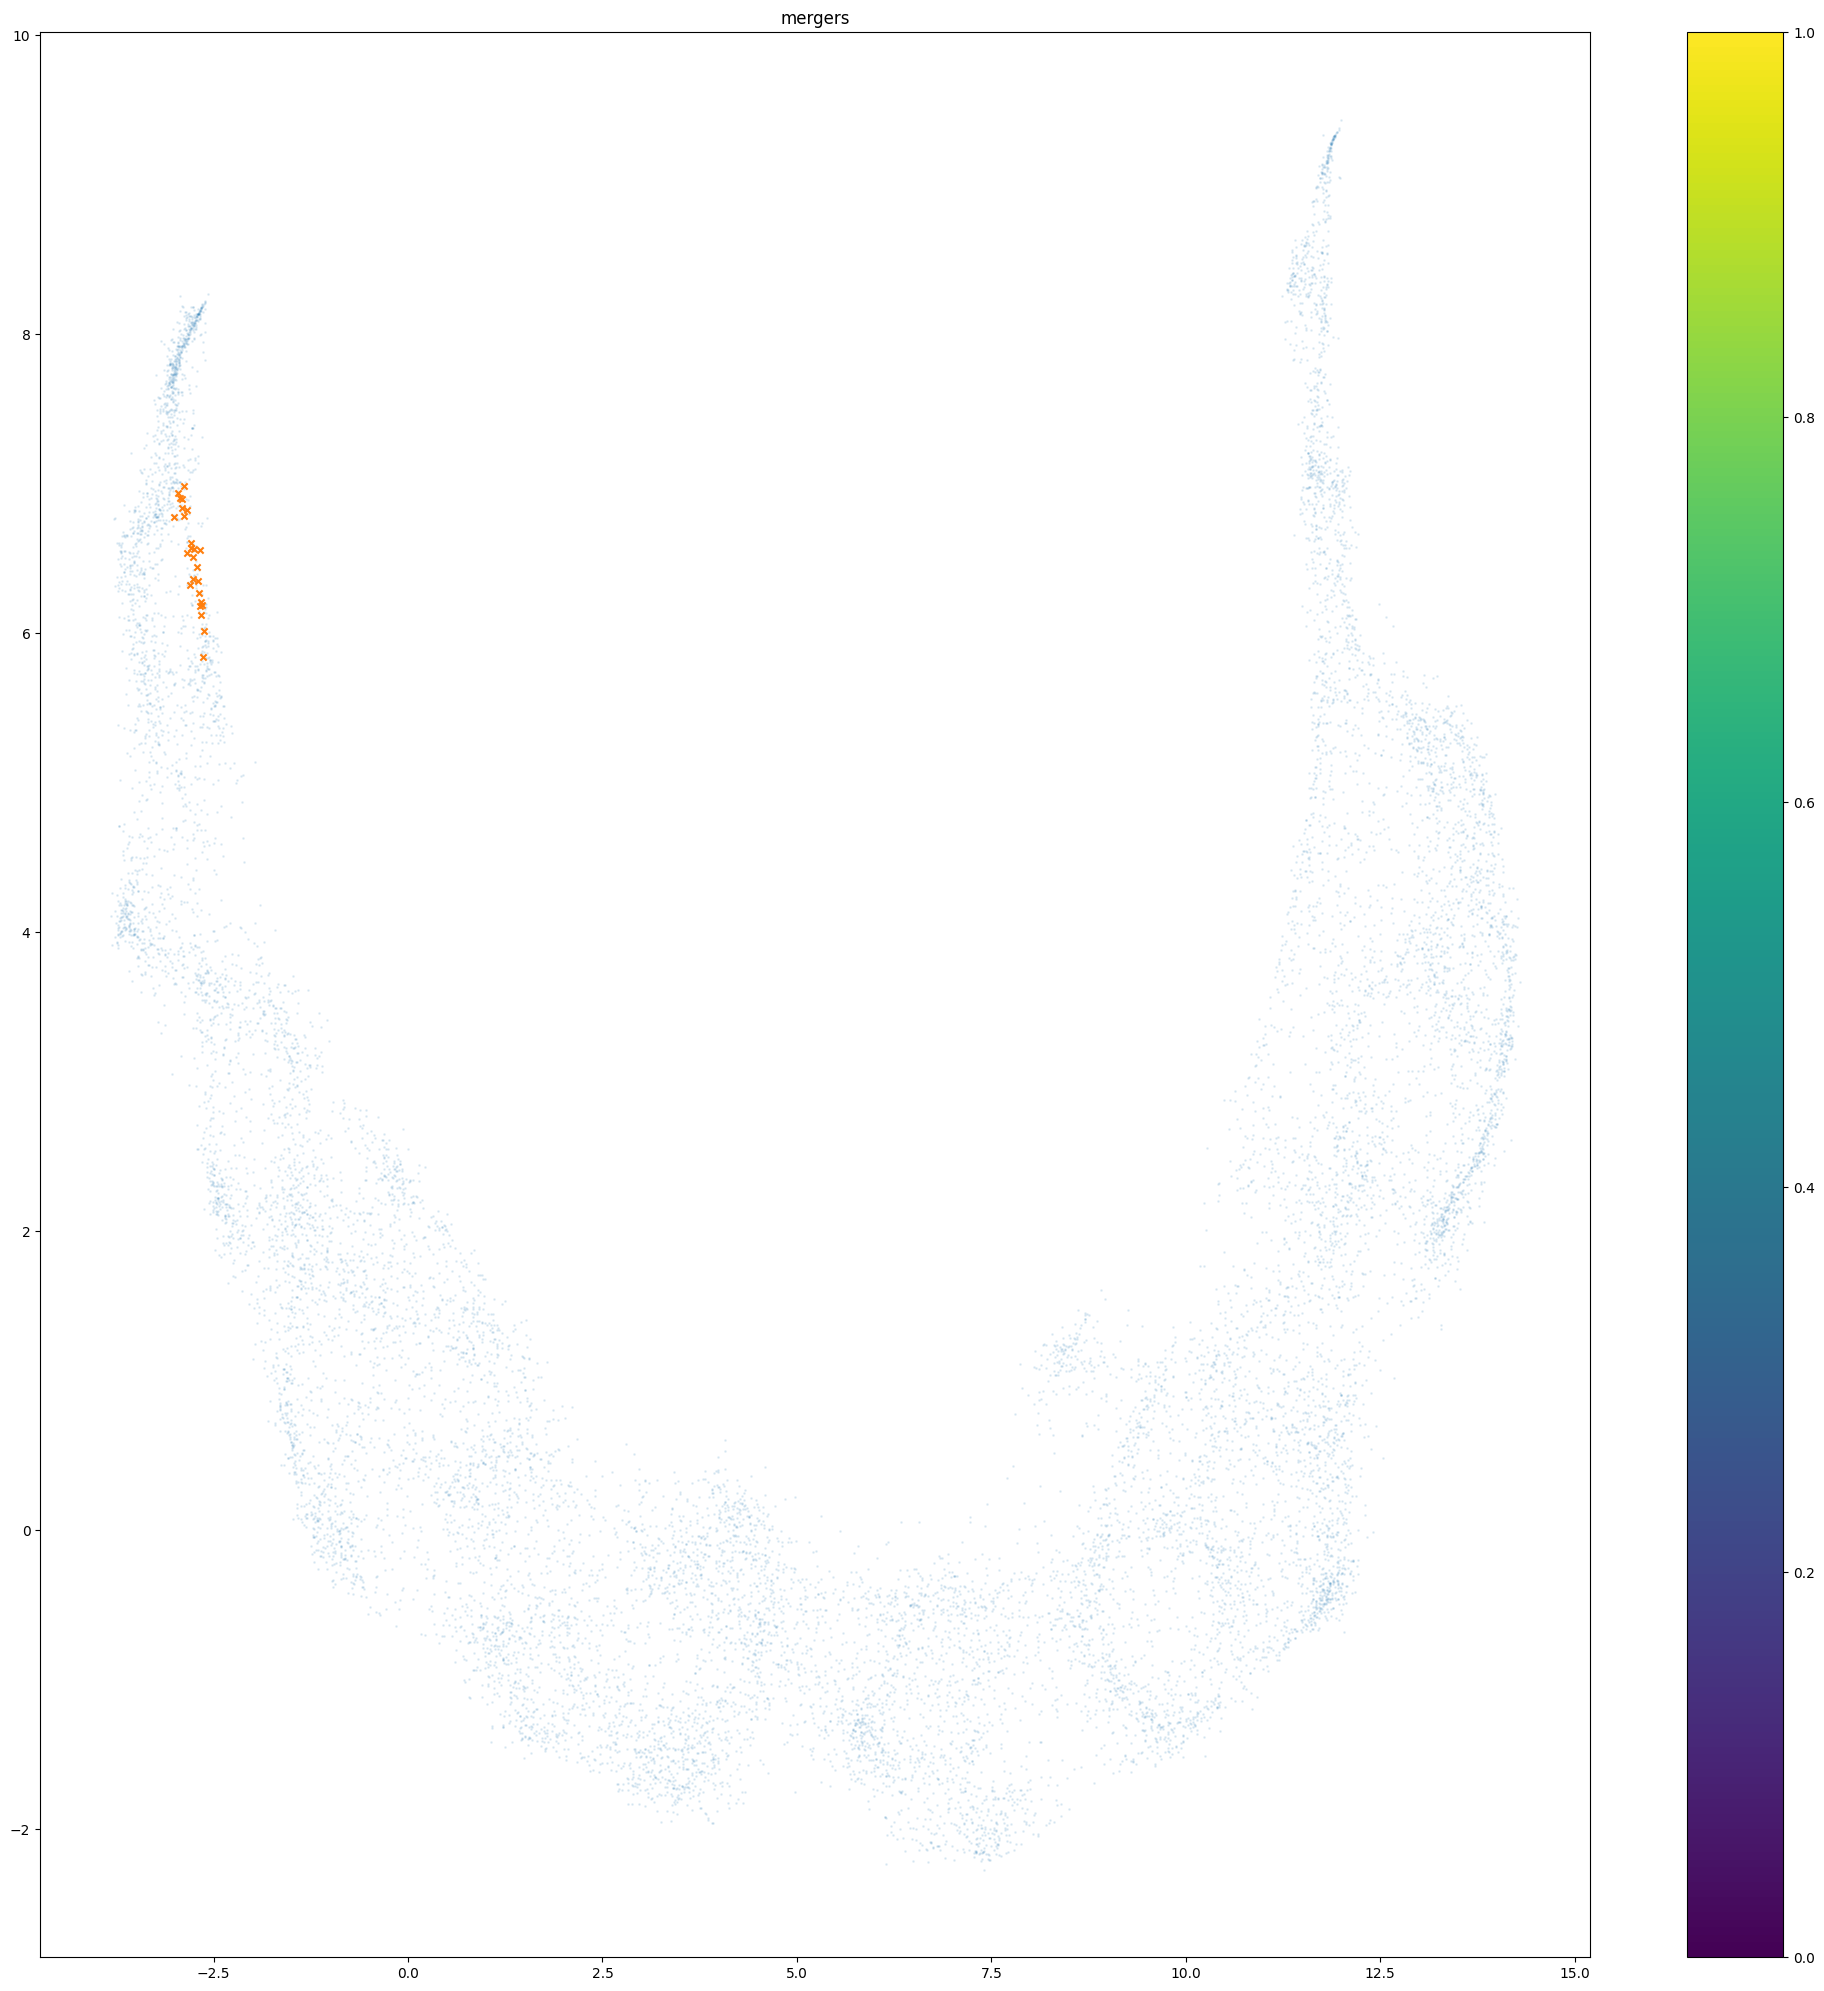

In [99]:
fig, axes = plt.subplots(1, 1, figsize=(25,25))

the_idx = ['611254866483884505', '611256447031854239', '609782276816913486', '611254866483886229', '609781589622129426', '609788736447725514', '609780833707902986', '609780902427367903', '609788736447727929', '611254591605977901', '611254866483886626', '611255278800748505', '609782276816910255', '611255278800752887', '611256584470806708', '609781452183185984', '611255965995515648', '611254591605983364', '611256447031851230', '609782276816910784', '611255691117615280', '609788186691912612', '611256584470800579', '609788667728239947', '609780764988427157']
the_idx = ['609788667728239378', '609781589622149000', '609781589622146743', '611255278800751261', '611254866483883349', '609781589622146910', '611254591605987716', '609781589622148410', '609788117972430024', '609789354923011356', '609781589622146757', '611254248008602801', '611255965995515915', '611256584470806644', '611256584470805623', '609788736447726513', '609782276816907704', '609788736447726514', '611256515751330523', '611256584470800559', '609788117972428945', '609788186691908062', '611254179289118356', '609788736447723861', '611254179289120892']


plot_umap_overlay(axes, config=None, key="total_mergers_fraction", threshold=0.6,
                      database=euclid_vissyn, input_dir="20251014-003804-umap-ccSi", alpha=0.1, s=1,
                     log_colorbar=True, title="mergers", print_rubin_ids=True, overriding_indices=the_idx)

[   50    58    63   421   473   638   652   678   698  1385  1386  1994
  1997  2038  2149  2200  2853  2927  3062  3063  3319  3330  3386  3988
  4051  4166  4394  4756  5363  5438  6050  6390  6421  6534  6594  6970
  7322  7642  7796  9220  9391 10013 10624 10659 11120 11448 11613 11714
 11746 11774 11932 13117 13350 13398 13817 14893 14980]
[609780764988419851 609780764988420132 609780764988420273
 609780833707901349 609780833707903122 609780902427367599
 609780902427367904 609780902427368496 609780902427369092
 609781589622144079 609781589622144080 609782276816911627
 609782276816911756 609782276816913205 609787499497128309
 609787499497131987 609788186691910420 609788186691912899
 609788255411383953 609788255411383954 609788667728238493
 609788667728238622 609788667728239378 609788805167204122
 609788805167207794 609788873886676344 609788873886686613
 609789423642491137 611253560813833023 611253560813835107
 611253835691738740 611254179289115819 611254179289116916
 6112541792891

<Axes: title={'center': 'mergers'}>

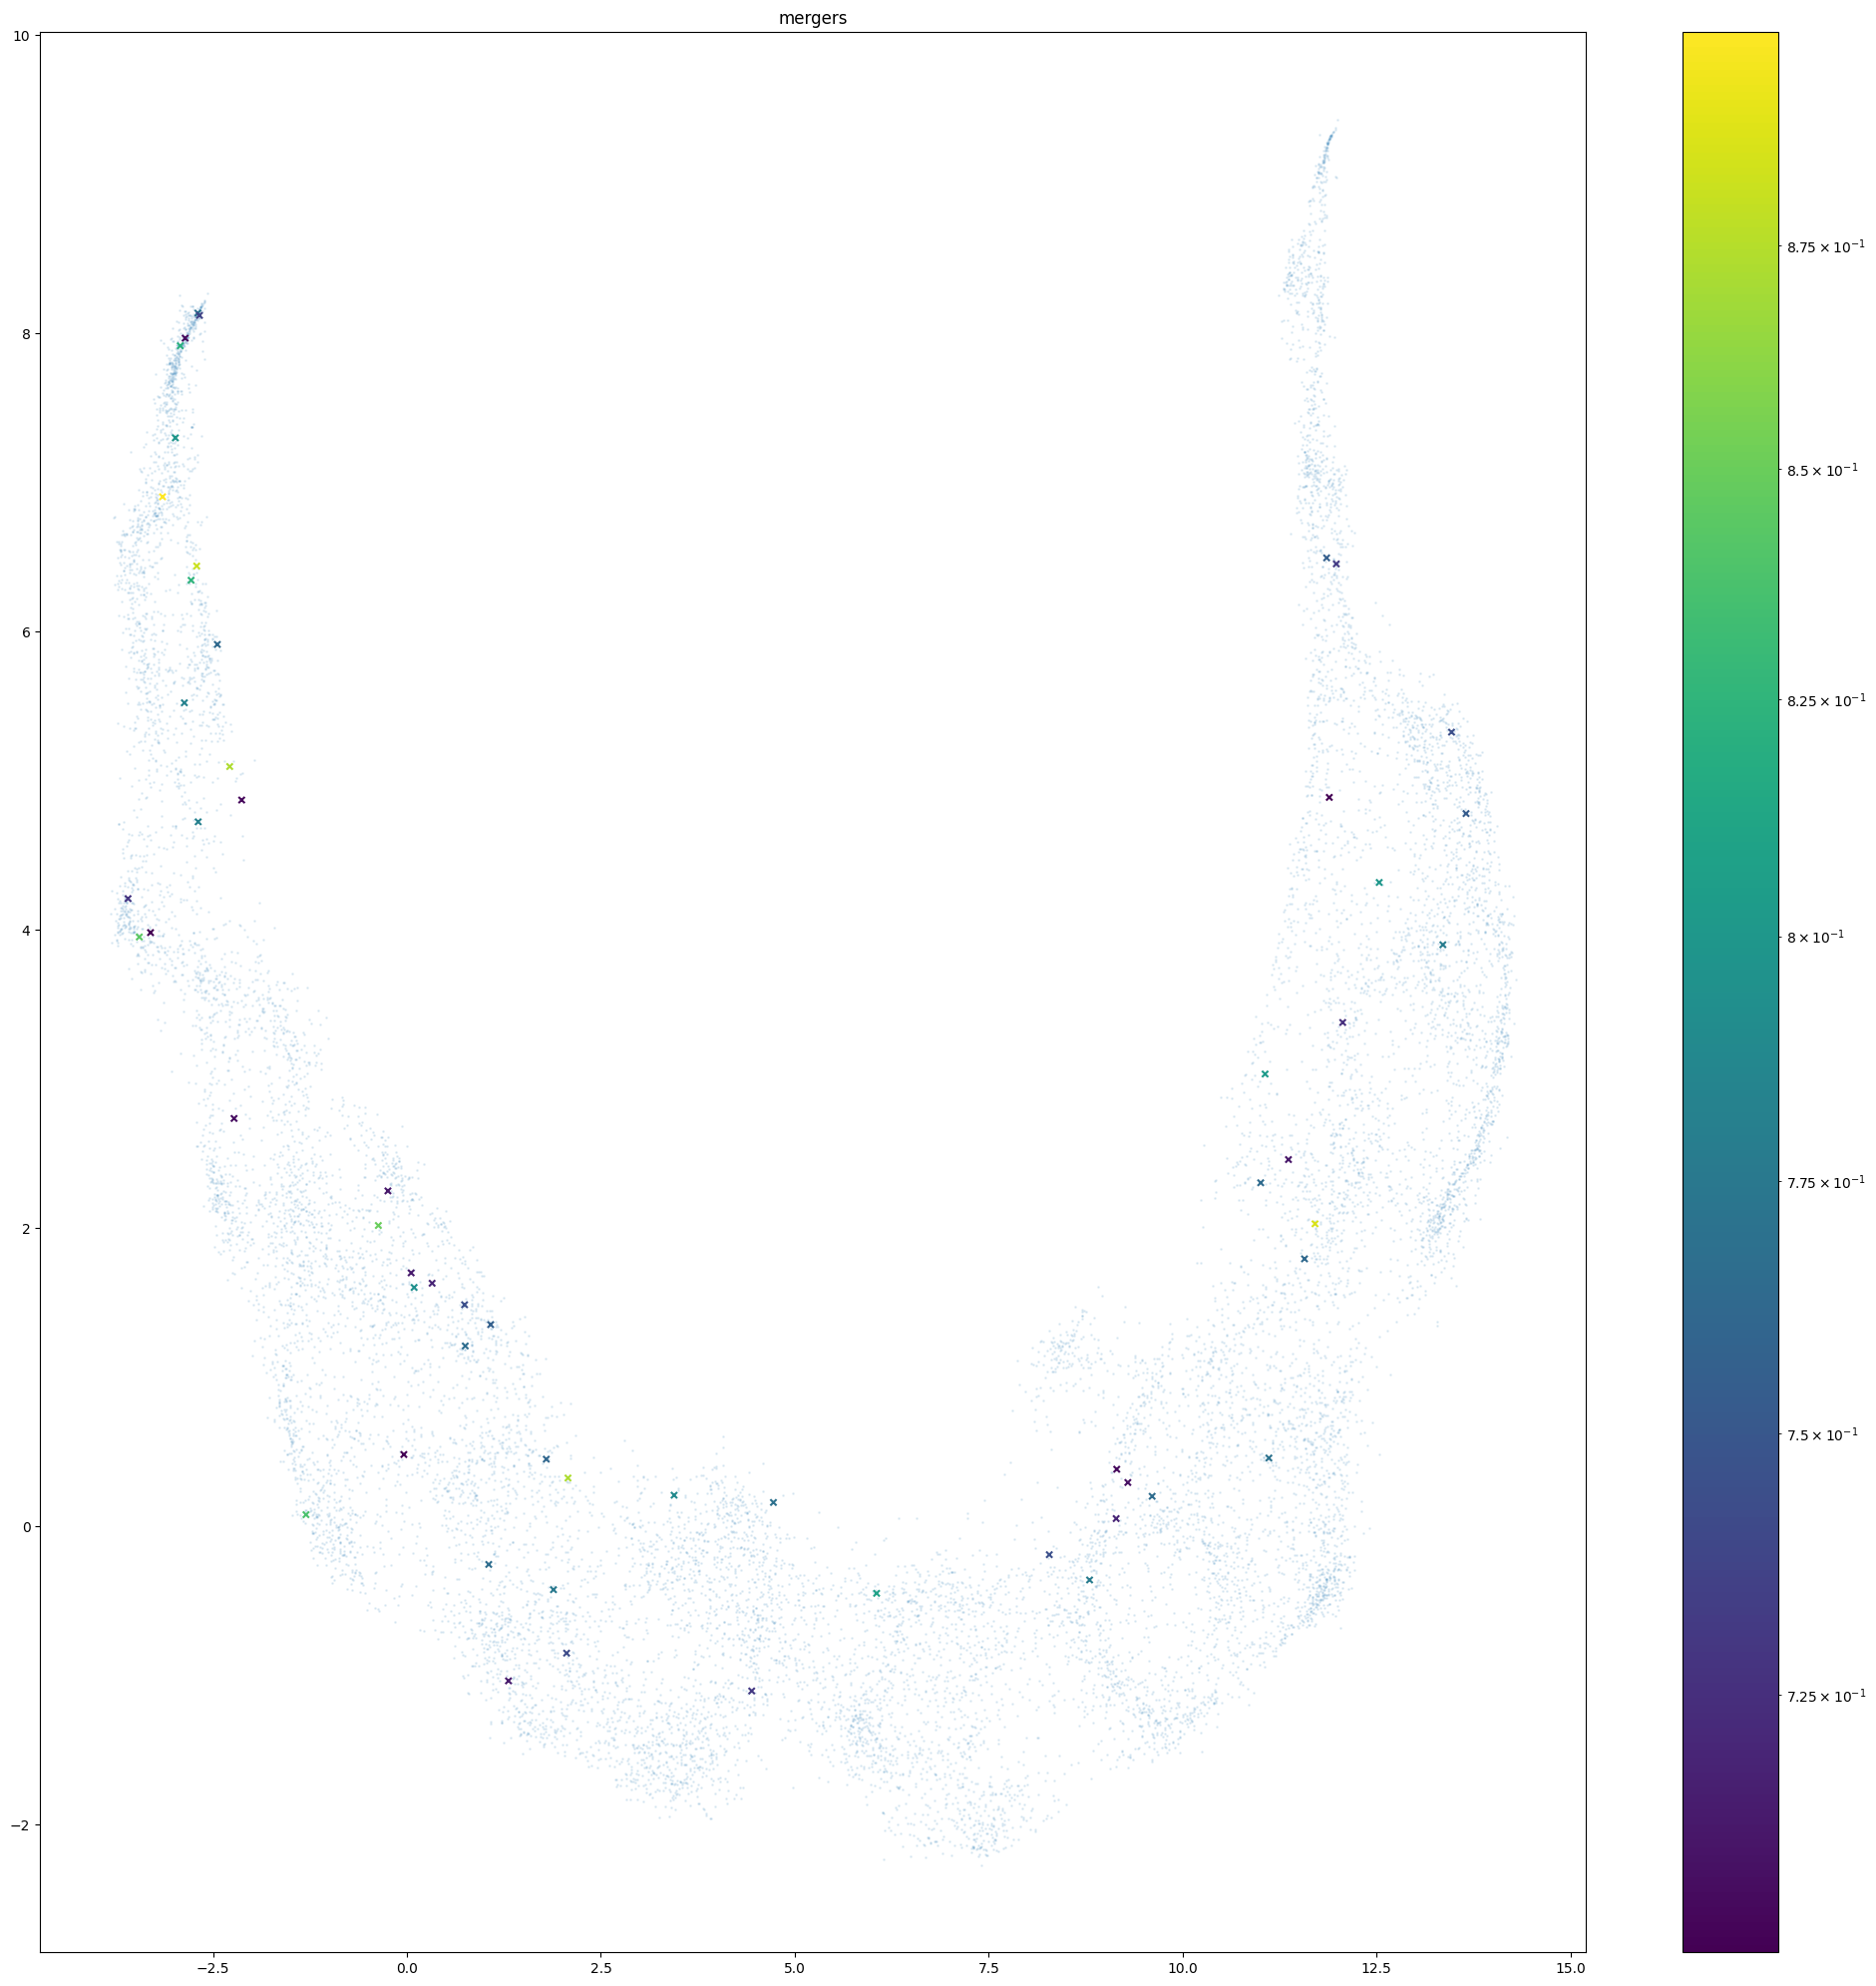

In [98]:
fig, axes = plt.subplots(1, 1, figsize=(25,25))

the_idx = ['611254866483884505', '611256447031854239', '609782276816913486', '611254866483886229', '609781589622129426', '609788736447725514', '609780833707902986', '609780902427367903', '609788736447727929', '611254591605977901', '611254866483886626', '611255278800748505', '609782276816910255', '611255278800752887', '611256584470806708', '609781452183185984', '611255965995515648', '611254591605983364', '611256447031851230', '609782276816910784', '611255691117615280', '609788186691912612', '611256584470800579', '609788667728239947', '609780764988427157']


plot_umap_overlay(axes, config=None, key="total_mergers_fraction", threshold=0.7,
                      database=euclid_vissyn, input_dir="20251014-003804-umap-ccSi", alpha=0.1, s=1,
                     log_colorbar=True, title="mergers", print_rubin_ids=True, overriding_indices=None)

In [28]:
run_08_df = pd.DataFrame(
    [["run_08_01", "20251013-133314-umap-AjoD"],
    ["run_08_02", "20251013-140213-umap-bKoR"],
    ["run_08_03", "20251013-143240-umap-RYgT"],
    ["run_08_04", "20251013-145232-umap-_x5t"],
    ["run_08_05", "20251013-151333-umap-ezJt"],
    ["run_08_03", "20251013-153702-umap-kYUl"],
    ["run_08_07", "20251013-155822-umap-8KoL"],
    ["run_08_08", "20251013-162002-umap-PSMq"],
    ["run_08_09", "20251013-164231-umap-KF2W"],
    ["run_08_10", "20251013-170338-umap-AHvm"],
    ["run_08_11", "20251013-172527-umap-DzQE"],
    ["run_08_12", "20251013-174841-umap--Wba"]], columns=["exp_name", "umap_filename"])

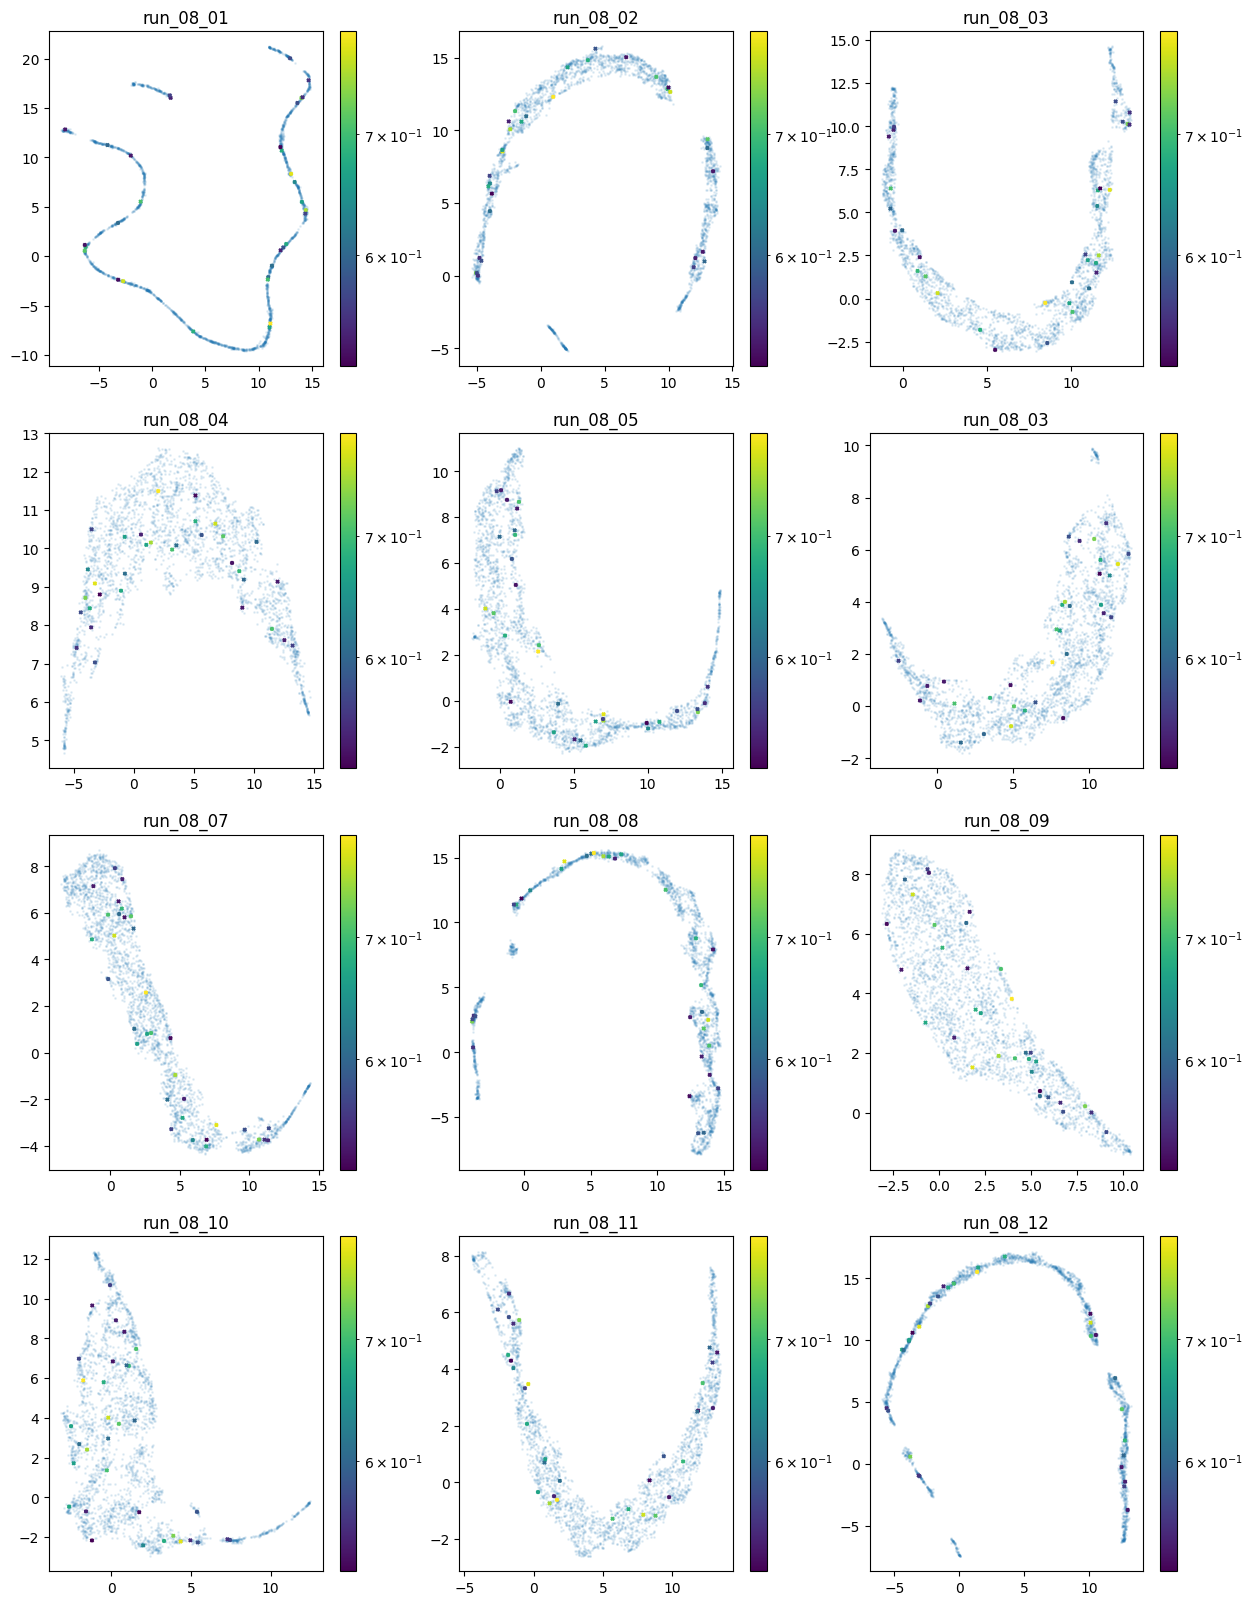

In [31]:
# Feature plots of all runs with `merger`

# Features of interest
# interested_cols = [
#     "smooth-or-featured_smooth_fraction",
#     "smooth-or-featured_featured-or-disk_fraction",
#     "merging_merger_fraction",
#     "merging_minor-disturbance_fraction",
#     "merging_major-disturbance_fraction",
#     "how-rounded_round_fraction",
#     # "how-rounded_cigar-shaped_fraction",
#     # "bar_strong_fraction",
#     # "disk-edge-on_yes_fraction",
# ]

expnum = 6

# thres_arr = [0.7, 0.7, 0.7, 0.3, 0.3, 0.7]

fig, axes = plt.subplots(4, 3, figsize=(15,20))

for i, ax in enumerate(axes.flatten()):
    plot_umap_overlay(ax, config=None, key="merging_merger_fraction", threshold=0.5,
                      database=euclid_vissyn, input_dir=run_08_df.loc[i, "umap_filename"], alpha=0.1, s=1,
                     log_colorbar=True, title=run_08_df.loc[i, "exp_name"])

In [23]:
run_09_df = pd.DataFrame(
    [["run_09_01", "20251014-003804-umap-ccSi"],
    ["run_09_02", "20251014-012418-umap-6WKk"],
    ["run_09_03", "20251014-020529-umap-Xc7a"],
    ["run_09_04", "20251014-024501-umap-fyV7"],
    ["run_09_05", "20251014-032528-umap-Cotf"],
    ["run_09_06", "20251014-040719-umap-NVkd"],
    ["run_09_07", "20251014-044631-umap-U6O8"],
    ["run_09_08", "20251014-052619-umap-Bqrx"],
    ["run_09_09", "20251014-060716-umap-nb5J"],
    ["run_09_10", "20251014-064713-umap-beeC"],
    ["run_09_11", "20251014-072745-umap-j9nQ"],
    ["run_09_12", "20251014-081002-umap-EuvG"]], columns=["exp_name", "umap_filename"])

In [54]:
# Modify vissyn table

# Do the union thing properly
euclid_vissyn["total_mergers_fraction"] = euclid_vissyn["merging_merger_fraction"] + euclid_vissyn["merging_major-disturbance_fraction"]


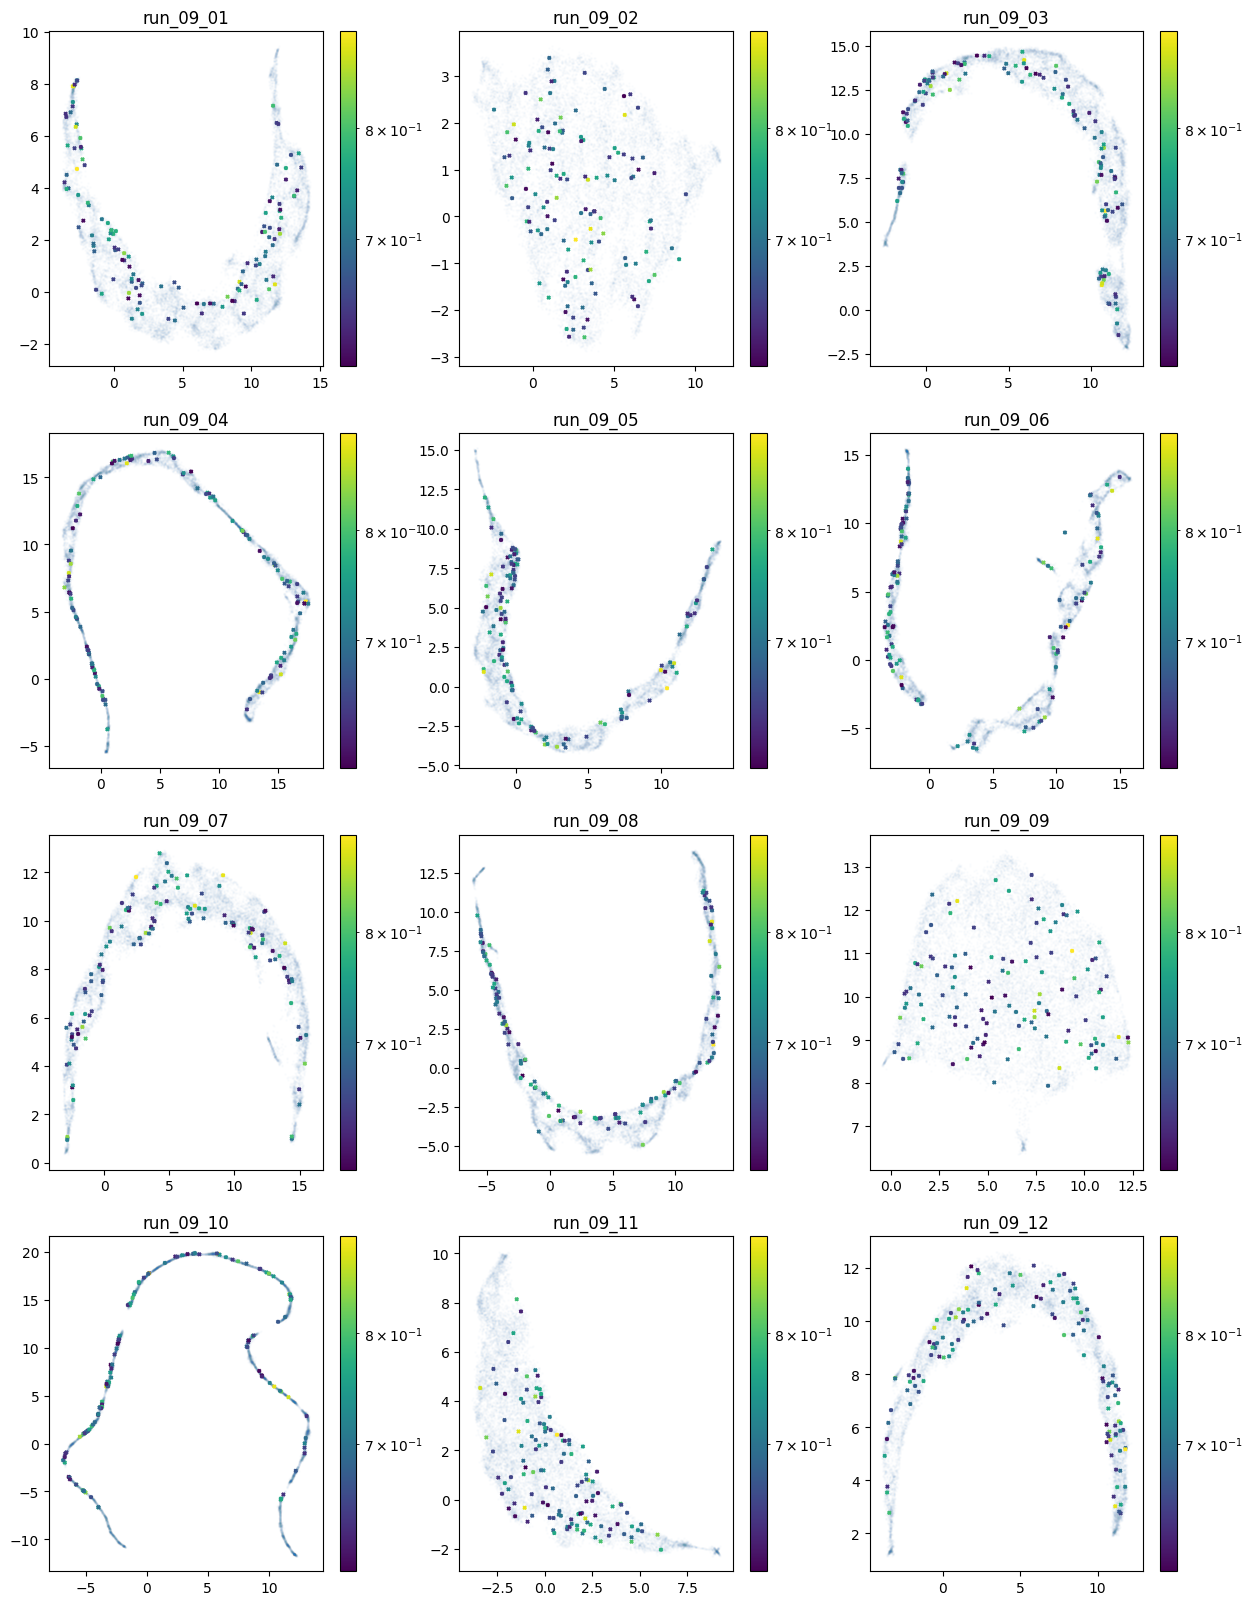

In [33]:
# Feature plots of all runs with `merger`

# Features of interest
# interested_cols = [
#     "smooth-or-featured_smooth_fraction",
#     "smooth-or-featured_featured-or-disk_fraction",
#     "merging_merger_fraction",
#     "merging_minor-disturbance_fraction",
#     "merging_major-disturbance_fraction",
#     "how-rounded_round_fraction",
#     # "how-rounded_cigar-shaped_fraction",
#     # "bar_strong_fraction",
#     # "disk-edge-on_yes_fraction",
# ]

expnum = 6

# thres_arr = [0.7, 0.7, 0.7, 0.3, 0.3, 0.7]

fig, axes = plt.subplots(4, 3, figsize=(15,20))

for i, ax in enumerate(axes.flatten()):
    plot_umap_overlay(ax, config=None, key="total_mergers_fraction", threshold=0.6,
                      database=euclid_vissyn, input_dir=run_09_df.loc[i, "umap_filename"], alpha=0.01, s=1,
                     log_colorbar=True, title=run_09_df.loc[i, "exp_name"])

In [26]:
run_10_2_df = pd.DataFrame(
    [["run_10_04", "20251016-225415-umap-RleA"],
    ["run_10_08", "20251017-011308-umap-WOnq"],
    ["run_10_09", "20251017-033351-umap-nK9h"]], columns=["exp_name", "umap_filename"])



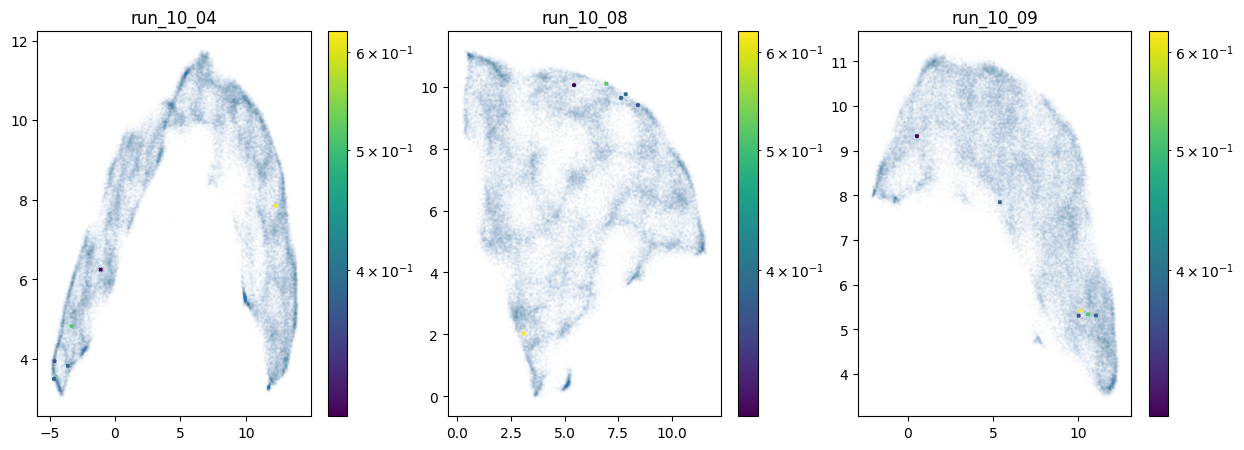

In [11]:
# Feature plots of all runs with `merger`

# Features of interest
# interested_cols = [
#     "smooth-or-featured_smooth_fraction",
#     "smooth-or-featured_featured-or-disk_fraction",
#     "merging_merger_fraction",
#     "merging_minor-disturbance_fraction",
#     "merging_major-disturbance_fraction",
#     "how-rounded_round_fraction",
#     # "how-rounded_cigar-shaped_fraction",
#     # "bar_strong_fraction",
#     # "disk-edge-on_yes_fraction",
# ]

expnum = 6

# thres_arr = [0.7, 0.7, 0.7, 0.3, 0.3, 0.7]

fig, axes = plt.subplots(1, 3, figsize=(15,5))

for i, ax in enumerate(axes.flatten()):
    plot_umap_overlay(ax, config=None, key="merging_merger_fraction", threshold=0.3,
                      database=euclid_vissyn, input_dir=run_10_2_df.loc[i, "umap_filename"], alpha=0.01, s=1,
                     log_colorbar=True, title=run_10_2_df.loc[i, "exp_name"])